# **Install Extra Libraries**

In [ ]:
%pip install pyfiglet
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 18.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import Libraries**

In [ ]:

import os
import random
import shutil
from pathlib import Path
from os.path import exists
import numpy as np
import sys
import math
import cv2
import urllib
from tqdm import tqdm
import requests


import torch
from matplotlib import pyplot as plt
from matplotlib import use as mpl_use
from pyfiglet import Figlet

import torch.nn as nn
import torchvision
from torchvision.models import resnet18

print('Import Complete')

Import Complete


# **Feature Extractor**

In [ ]:
def get_name_to_module(model):
    name_to_module = {}
    for m in model.named_modules():
        name_to_module[m[0]] = m[1]
    return name_to_module


def get_activation(all_outputs, name):
    def hook(model, input, output):
        all_outputs[name] = output.detach()

    return hook


def add_hooks(model, outputs, output_layer_names):
    """
    :param model:
    :param outputs: Outputs from layers specified in `output_layer_names` will be stored in `output` variable
    :param output_layer_names:
    :return:
    """
    name_to_module = get_name_to_module(model)
    for output_layer_name in output_layer_names:
        name_to_module[output_layer_name].register_forward_hook(get_activation(outputs, output_layer_name))


class ModelWrapper(nn.Module):
    def __init__(self, model, output_layer_names, return_single=True):
        super(ModelWrapper, self).__init__()

        self.model = model
        self.output_layer_names = output_layer_names
        self.outputs = {}
        self.return_single = return_single
        add_hooks(self.model, self.outputs, self.output_layer_names)

    def forward(self, images):
        self.model(images)
        output_vals = [self.outputs[output_layer_name] for output_layer_name in self.output_layer_names]
        if self.return_single:
            return output_vals[0]
        else:
            return output_vals


class BBResNet18(object):
    def __init__(self):
        self.model = resnet18(pretrained=True)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model.eval()

        self.model = ModelWrapper(self.model, ['avgpool'], True)

        self.model.eval()
        self.model.to(self.device)

    def feature_extraction(self, x: np.ndarray):
        '''
            param:
                x: numpy ndarray of shape: [None, 3, 224, 224] and dtype: np.float32
            
            return:
                numpy ndarray (feature vector) of shape: [None, 512] and dtype: np.float32
        '''

        x = torch.from_numpy(x).to(self.device)

        with torch.no_grad():
            out = self.model(x).cpu().detach()
            out = out.view(out.size(0), -1)
            out = out.numpy()

        return out


# **Utility Fuctions**

In [ ]:
def download_dataset():
    print('Downloading CIFAR Dataset')
    import tarfile
    print('Download Complete. Extracting ...')
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    response = requests.get(url, stream=True)
    file = tarfile.open(fileobj=response.raw, mode="r|gz")
    file.extractall(path=".")
    print('Extraction Completed')

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

# Function for checking the internet connectivity

def connect(host='http://google.com'):
    try:
        urllib.request.urlopen(host)  # Python 3.x
        return True
    except:
        return False

def url_exists(path):
    r = requests.head(path)
    return r.status_code == requests.codes.ok

# Unpack the dataset using pickle library
def unpickle(folder):
    labels_mapping = {}
    # np.set_printoptions(threshold=sys.maxsize)
    train_data = {'data': np.array([]), 'labels': []}
    test_data = {'data': np.array([]), 'labels': []}
    print(os.listdir(folder))
    for file in os.listdir(folder):
        if file == "data_batch_1" or file == "data_batch_2" or file == "data_batch_3" or file == "data_batch_4" or file == "data_batch_5":
            print('Currently Processing File : ', file)
            dict = unpickle_each(os.path.join(folder, file))
            if train_data['data'].shape[0] == 0:
                train_data['data'] = dict[b'data']
            else:
                train_data['data'] = np.vstack([train_data['data'], dict[b'data']])
            train_data['labels'] = train_data['labels'] + dict[b'labels']
        elif file == 'batches.meta':
            print('Currently Processing File : ', file)
            labels_mapping = unpickle_each(os.path.join(folder, file))
        elif file == 'test_batch':
            print('Currently Processing File : ', file)
            dict = unpickle_each(os.path.join(folder, file))
            if test_data['data'].shape[0] == 0:
                test_data['data'] = dict[b'data']
            test_data['labels'] = test_data['labels'] + dict[b'labels']
    return train_data, test_data, labels_mapping
    # with open(file, 'rb') as fo:
    #     dict = pickle.load(fo, encoding='bytes')
    # return dict

def unpickle_each(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def preprocessing(data):
    images = []
    count = 1
    for img in data['data']:
        img_new = img.reshape((3, 32, 32))
        # print(img_new[0][0][0])
        image = np.transpose(img_new, [1, 2, 0])
        images.append(image)
    return np.array(images)


def img_enhancement(img):
    # print(img)
    arr_pxl = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            avg = np.average(img[i, j])
            arr_pxl.append(avg)
    imax = np.max(arr_pxl)
    imin = np.min(arr_pxl)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pxl = []
            avg = np.average(img[i, j])
            ip = 255 * (avg - imin) / (imax - imin)
            for c in range(img.shape[2]):
                if img[i, j, c] == 0:
                    n_pxl = 0
                else:
                    n_pxl = int((img[i, j, c] * ip / avg))
                pxl.append(n_pxl)
            img[i, j, :] = np.array(pxl)
            # print(img.shape)
    return img, img.shape


def img_posterization(img):
    imin = random.randint(30, 50)
    imax = random.randint(100, 150)
    range_pxl = abs(imax - imin)
    divider = 255 / range_pxl

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pxl = []
            for c in range(img.shape[2]):
                cont_pxl = (img[i, j, c] / divider)
                cont_pxl = (cont_pxl + imin)
                pxl.append(cont_pxl)
            img[i, j, :] = np.array(pxl).clip(0, 255)
    return img, img.shape


# This function rotates the image around its center by random degree between [-180, 180].
def random_rotation(image):
    # Choose Random degree
    degree = random.randint(-180, 180)
    # print("Random degree chosen: ", degree)
    # First we will convert the degrees into radians
    rads = math.radians(degree)
    cosine = math.cos(rads)
    sine = math.sin(rads)

    # Find the height and width of the rotated image using cosine and sine transformations
    height_rot_img = round(abs(image.shape[0] * cosine)) + round(abs(image.shape[1] * sine))
    width_rot_img = round(abs(image.shape[1] * cosine)) + round(abs(image.shape[0] * sine))

    # Initialising the rotated image by zeros
    rot_img = np.uint8(np.zeros((height_rot_img, width_rot_img, image.shape[2])))

    # Finding the center point of the original image
    orgx, orgy = (image.shape[1] // 2, image.shape[0] // 2)

    # Finding the center point of rotated image.
    rotx, roty = (width_rot_img // 2, height_rot_img // 2)

    for i in range(rot_img.shape[0]):
        for j in range(rot_img.shape[1]):
            # Find the all new coordinates for orginal image wrt the new center point
            x = (i - rotx) * cosine + (j - roty) * sine
            y = -(i - rotx) * sine + (j - roty) * cosine

            x = round(x) + orgy
            y = round(y) + orgx

            # Restricting the index in between original height and width of image.
            if x >= 0 and y >= 0 and x < image.shape[0] and y < image.shape[1]:
                rot_img[i, j, :] = image[x, y, :]
    return rot_img, degree


def contrast_and_flip(image):
    img_height = image.shape[0]
    img_width = image.shape[1]
    # Adding two pixels padding across the image
    img = np.uint8(np.zeros((img_height, img_width, image.shape[2])))

    alpha = random.uniform(0.5, 2.0)
    flip_prob = random.randint(0, 1)
    # print("Alpha value: ", alpha)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pxl = []
            for c in range(image.shape[2]):
                cont_pxl = int(alpha * (image[i, j, c] - 128) + 128)
                if cont_pxl > 255:
                    cont_pxl = 255
                elif cont_pxl < 0:
                    cont_pxl = 0
                pxl.append(cont_pxl)
            img[i, j, :] = np.array(pxl)
    if (flip_prob):
        # print("Including Horizontal Flipping")
        img = img[:, ::-1, :]  # Horizontal Flipping
    return img, round(alpha, 3)


# Generating Augmented Images
def get_augmented_images(data, labels):
    augmented_img = []
    augmented_labels = []
    preprocess_func = {0: random_rotation, 1: img_enhancement, 2: img_posterization, 3: contrast_and_flip}
    i = 0
    # print(data)
    for img in data:
        rndm_idx = random.randint(0, 3)
        if i % 1000 == 0:
            print("\nProcessing Image Number: ", i, end=' ')
        # Resizing to restore rotated image's dimensions to 32 x 32
        if preprocess_func[rndm_idx] != random_rotation:
            n_img, _ = preprocess_func[rndm_idx](img)
        else:
            # print(img)
            n_img, _ = preprocess_func[rndm_idx](img)
            n_img = cv2.resize(n_img, (32, 32))
        augmented_img.append(n_img)
        augmented_labels.append(labels[i])
        i += 1
    return np.array(augmented_img), augmented_labels


def get_feat_vec(images, obj):
    feat_vec = []
    count = 1
    for img in images:
        # print(count)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 1, 0))
        # Performing Normalization before sending into ResNet model
        img = img / 255
        img = np.array(img, dtype=np.float32)
        feat_vec.append(obj.feature_extraction(np.array([img]))[0])
        count += 1
    return np.array(feat_vec)


# **Download CIFAR-10 Dataset**

In [ ]:
f = Figlet(font='slant')
print(f.renderText('CS774 Assignment 1'))

f = Figlet(font='digital')
print(f.renderText('by Anjali Manoj and Atanu Shuvam Roy'))

# Check for internet
print(
    "Connected to Internet. Ready for duty." if connect() else "No Internet! Put Extracted Dataset in current directory")

dir = 'cifar-10-batches-py'
file_exists = exists('cifar-10-python.tar.gz')
dir_exists = exists(dir)
if file_exists:
    print('Previous File Exists. Removing File ...')
    os.unlink('cifar-10-python.tar.gz')
elif dir_exists:
    files_required = ['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5',
                      'test_batch']
    flag = True
    for i in files_required:
        path = Path(dir + f'/{i}')
        if not path.is_file():
            flag = False
            break
    if flag:
        print('Dataset already available')
    else:
        print('Dataset Incomplete. Re-download required')
        shutil.rmtree(dir)
else:
    print('Dataset Unavailable. Connecting to internet ...')
    download_dataset()

   _______________________ __
  / ____/ ___/__  /__  / // /
 / /    \__ \  / /  / / // /_
/ /___ ___/ / / /  / /__  __/
\____//____/ /_/  /_/  /_/   
                             
    ___              _                                  __     ___
   /   |  __________(_)___ _____  ____ ___  ___  ____  / /_   <  /
  / /| | / ___/ ___/ / __ `/ __ \/ __ `__ \/ _ \/ __ \/ __/   / / 
 / ___ |(__  |__  ) / /_/ / / / / / / / / /  __/ / / / /_    / /  
/_/  |_/____/____/_/\__, /_/ /_/_/ /_/ /_/\___/_/ /_/\__/   /_/   
                   /____/                                         

+-+-+ +-+-+-+-+-+-+ +-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+ +-+-+-+-+-+-+ +-+-+-+
|b|y| |A|n|j|a|l|i| |M|a|n|o|j| |a|n|d| |A|t|a|n|u| |S|h|u|v|a|m| |R|o|y|
+-+-+ +-+-+-+-+-+-+ +-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+ +-+-+-+-+-+-+ +-+-+-+

Connected to Internet. Ready for duty.
Dataset Unavailable. Connecting to internet ...
Download Complete. Extracting ...
Extraction Completed


# **Load The Dataset**

In [ ]:
f = Figlet(font='digital')
print(f.renderText('Question 1: Loading the dataset'))

train_data, test_data, labels_mapping = unpickle(dir)

# np.set_printoptions(threshold=sys.maxsize)
# print(train_data['data'][0])

print("Total train data size:", train_data['data'].shape)
print("Total test data size:", test_data['data'].shape)
print("Labels available for CIFAR-10: ", labels_mapping[b'label_names'])

+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |1|:| |L|o|a|d|i|n|g| |t|h|e| |d|a|t|a|s|e|t|
+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+-+-+

['data_batch_1', 'test_batch', 'data_batch_5', 'data_batch_2', 'batches.meta', 'readme.html', 'data_batch_3', 'data_batch_4']
Currently Processing File :  data_batch_1
Currently Processing File :  test_batch
Currently Processing File :  data_batch_5
Currently Processing File :  data_batch_2
Currently Processing File :  batches.meta
Currently Processing File :  data_batch_3
Currently Processing File :  data_batch_4
Total train data size: (50000, 3072)
Total test data size: (10000, 3072)
Labels available for CIFAR-10:  [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# **Image Processing/Augmentation**

+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |2| |(|a|)|:| |I|m|a|g|e| |E|n|h|a|n|c|e|m|e|n|t|
+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+



<Figure size 144x144 with 0 Axes>

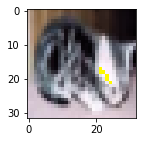

+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |2| |(|b|)|:| |P|o|s|t|e|r|i|z|a|t|i|o|n| |o|f| |I|m|a|g|e|
+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+



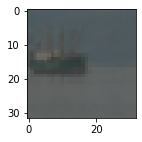

+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+ +-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |2| |(|c|)|:| |R|a|n|d|o|m| |R|o|t|a|t|e|
+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+ +-+-+-+-+-+-+



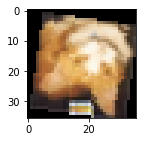

+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |2| |(|d|)|:| |C|o|n|t|r|a|s|t| |a|n|d| |H|o|r|i|z|o|n|t|a|l|
+-+-+-+-+-+-+-+-+ +-+ +-+-+-+-+ +-+-+-+-+-+-+-+-+ +-+-+-+ +-+-+-+-+-+-+-+-+-+-+
+-+-+-+-+-+-+-+-+
|F|l|i|p|p|i|n|g|
+-+-+-+-+-+-+-+-+



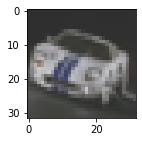

In [ ]:
# Question 2: Image transformations

f = Figlet(font='digital')
print(f.renderText('Question 2 (a): Image Enhancement'))

org_train_images = preprocessing(train_data)
org_test_images = preprocessing(test_data)

# Test Image for applying image enhancement
first_image = org_train_images[0]

# Matplotlib Backend Specify to ignore the bug (MacOSX)
# mpl_use('MacOSX')
plt.figure(figsize=(2, 2))
# plt.imshow(first_image)
# plt.show()

# Question 2 (a)
plt.figure(figsize=(2, 2))
first_image = org_train_images[random.randint(0, 49000)]
enhanced_image, _ = img_enhancement(first_image)
plt.imshow(enhanced_image)
plt.show()

# Question 2 (b)
print(f.renderText('Question 2 (b): Posterization of Image'))
first_image = org_train_images[random.randint(0, 49000)]
posterized_image, _ = img_posterization(first_image)
plt.figure(figsize=(2, 2))
plt.imshow(posterized_image)
plt.show()

# Question 2 (c)
print(f.renderText('Question 2 (c): Random Rotate'))
first_image = org_train_images[random.randint(0, 49000)]
rotated_image, rotated_degree = random_rotation(first_image)
plt.figure(figsize=(2, 2))
plt.imshow(rotated_image)
plt.show()

print(f.renderText('Question 2 (d): Contrast and Horizontal Flipping'))
first_image = org_train_images[random.randint(0, 49000)]
contrast_image, alpha = contrast_and_flip(first_image)
plt.figure(figsize=(2, 2))
plt.imshow(contrast_image)
plt.show()

# **Augmented Image Set**

In [ ]:
print(f.renderText('Question 3: Augmented Images'))

# Generating Augmented Images
cifar_augmented_dir = './cifar-10-batches-augmented-py'
# Check whether the specified path exists or not
isExist = os.path.exists(cifar_augmented_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(cifar_augmented_dir)
    print("The new directory (cifar-10-batches-augmented-py) is created!")

print('Checking for preprocessed augmented data')
if os.path.exists(cifar_augmented_dir + '/augmented_batch.npy') and os.path.exists(cifar_augmented_dir + '/augmented_batch_labels.npy'):
    print('Preprocessed augmented data found. Loading Data')
    augmented_train_set = np.load(cifar_augmented_dir + '/augmented_batch.npy')
    augmented_train_labels = np.load(cifar_augmented_dir + '/augmented_batch_labels.npy')
else:
    print('Preprocessed augmented data NOT found. Checking Online ...')
    aug_batch_url ="https://cse.iitk.ac.in/users/atanusroy/augmented_batch.npy";
    aug_batch_labels_url ="https://cse.iitk.ac.in/users/atanusroy/augmented_batch_labels.npy";
    if(url_exists(aug_batch_url) and url_exists(aug_batch_labels_url)):
      download_url(aug_batch_url, cifar_augmented_dir + '/augmented_batch.npy')
      download_url(aug_batch_labels_url, cifar_augmented_dir + '/augmented_batch_labels.npy')
      augmented_train_set = np.load(cifar_augmented_dir + '/augmented_batch.npy')
      augmented_train_labels = np.load(cifar_augmented_dir + '/augmented_batch_labels.npy')
    else:
      print('File Not Available Online. Regenerating Augmented Dataset ...')
      train_augmented_img, train_augmented_labels = get_augmented_images(org_train_images, train_data['labels'])
      augmented_train_set = np.vstack([org_train_images, train_augmented_img])
      augmented_train_labels = train_data['labels'] + train_augmented_labels
      np.save(cifar_augmented_dir + '/augmented_batch.npy', augmented_train_set)
      np.save(cifar_augmented_dir + '/augmented_batch_labels.npy', augmented_train_labels)
      print('Augmented Data Shape: ', train_augmented_img.shape)
    print("Original Data Shape: ", org_train_images.shape)
print('Size of New Training Data Set: ', len(augmented_train_set))

+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |3|:| |A|u|g|m|e|n|t|e|d| |I|m|a|g|e|s|
+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+-+-+ +-+-+-+-+-+-+

The new directory (cifar-10-batches-augmented-py) is created!
Checking for preprocessed augmented data
Preprocessed augmented data NOT found. Checking Online ...


augmented_batch.npy: 307MB [20:03, 255kB/s]                           
augmented_batch_labels.npy: 803kB [00:05, 151kB/s]                           


Original Data Shape:  (50000, 32, 32, 3)
Size of New Training Data Set:  100000


# **Get Feature Vectors**

In [ ]:
print(f.renderText('Question 4: Feature Vector'))

obj = BBResNet18()

feature_vec_dir = './feature_vectors'
# Check whether the specified path exists or not
isExist = os.path.exists(feature_vec_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(feature_vec_dir)
    print("The new directory (feature_vec_dir) is created!")

if exists('./feature_vectors/original_train_feature_vector.npy') and exists(
        './feature_vectors/original_test_feature_vector.npy'):
    print("Loading Original Data Training Feature Vector")

    original_train_feat_vec = np.load('./feature_vectors/original_train_feature_vector.npy')
    original_test_feat_vec = np.load('./feature_vectors/original_test_feature_vector.npy')
else:
    print("Generating Original Data Training Feature Vector")

    original_train_feat_vec = get_feat_vec(org_train_images, obj)
    original_test_feat_vec = get_feat_vec(org_test_images, obj)

    np.save('./feature_vectors/original_train_feature_vector.npy', original_train_feat_vec)
    np.save('./feature_vectors/original_test_feature_vector.npy', original_test_feat_vec)

+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+ +-+-+-+-+-+-+
|Q|u|e|s|t|i|o|n| |4|:| |F|e|a|t|u|r|e| |V|e|c|t|o|r|
+-+-+-+-+-+-+-+-+ +-+-+ +-+-+-+-+-+-+-+ +-+-+-+-+-+-+



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

The new directory (feature_vec_dir) is created!
Generating Original Data Training Feature Vector


KeyboardInterrupt: ignored

# **MLP IMPLEMENTATION**

In [ ]:
# from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

def relu(x, deriv=False):
    # ReLU activation function
    if (deriv):
        return np.where(x <= 0, 0, 1)
    return np.maximum(x, 0)


def softmax(x):
    '''
        softmax(x) = exp(x) / sum(exp(x))
    '''

    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    prob = exp_values / np.sum(exp_values, axis=1, keepdims=True)
    return prob


def cross_entropy_loss(predicted, target):
    """
    predicted (batch_size x num_classes)
    target is labels (batch_size x 1)
    """
    log_likelihood = -np.log(predicted[range(target.shape[0]), target])
    loss = -np.sum(log_likelihood) / target.shape[0]
    # print("Loss: ", np.sum(loss))
    # exit()
    return loss


def get_one_hot_vector(y):
    """
    generating one hot vector for class labels
    """
    y = np.array(y)
    y_one_hot = np.zeros((y.shape[0], 10))
    y_one_hot[np.arange(y.shape[0]), y] = 1
    # y_one_hot = y_one_hot.reshape(-1, 10, 1)
    return y_one_hot


class MLP(object):
    def __init__(self, input_size, load_model_weights, augmented):
        if load_model_weights:
            print("Loading from pretrained model")
            if (augmented):
                read_weights = np.load(load_model_weights + '/augmented-model_weights.npy', allow_pickle='TRUE').item()
            else:
                read_weights = np.load(load_model_weights + '/unaugmented-model_weights.npy',
                                       allow_pickle='TRUE').item()
            self.weights = read_weights['weights']
            self.biases = read_weights['biases']
        else:
            print("Initialising weights and biases")

            self.weights = [np.random.randn(y, x) * 0.1 for x, y in
                            zip(input_size[:-2], input_size[1:-1])] + [
                               np.random.randn(input_size[-1], input_size[-2]) * 0.1]
            self.biases = [np.zeros((x, 1)) for x in input_size[1:-1]] + [np.zeros((input_size[-1], 1))]

        print("Weights Shape for Input Layer: ", self.weights[0].shape)
        print("Weights Shape for Hidden Layer 1: ", self.weights[1].shape)
        print("Weights Shape for Hidden Layer 2: ", self.weights[2].shape)

        print("Bias Shape for Input Layer: ", self.biases[0].shape)
        print("Bias Shape for Hidden Layer 1: ", self.biases[1].shape)
        print("Bias Shape for Hidden Layer 2: ", self.biases[2].shape)

    def feedforward(self, x):

        z1 = np.dot(self.weights[0], x) + self.biases[0][:, :x.shape[1]]
        a1 = relu(z1)
        z2 = np.dot(self.weights[1], a1) + self.biases[1][:, :a1.shape[1]]
        a2 = relu(z2)
        z3 = np.dot(self.weights[2], a2) + self.biases[2][:, :a2.shape[1]]
        a3 = softmax(z3.T)

        return z1, a1, z2, a2, z3, a3

    def backpropagation(self, X, y):

        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]

        z1, a1, z2, a2, z3, a3 = self.feedforward(X)
        y = y.argmax(axis=1)
        loss = cross_entropy_loss(a3, y)
        a3[range(y.shape[0]), y] -= 1
        error = a3

        # For Output Layer
        delta1 = error.T
        delta_b[2] = delta1
        delta_w[2] = np.dot(delta1, a2.T)

        # For Second Hidden Layer
        deriv_relu = relu(z2, deriv=True)
        delta2 = np.dot(self.weights[2].T, delta1) * deriv_relu
        delta_b[1] = delta2
        delta_w[1] = np.dot(delta2, a1.T)

        # For First Hidden Layer
        deriv_relu = relu(z1, deriv=True)
        delta3 = np.dot(self.weights[1].T, delta2) * deriv_relu
        delta_b[0] = delta3
        delta_w[0] = np.dot(delta3, X.T)

        return loss, delta_b, delta_w

    def evaluate(self, X, y):

        count = 0
        preds = np.array([])
        for x, _y in zip(X, y):
            _, _, _, _, _, a3 = self.feedforward(np.array([x]).T)
            preds = np.append(preds, np.argmax(a3))
            if np.argmax(a3) == np.argmax(_y):
                count += 1
        return float(count) / X.shape[0], preds

    def train(self, X, y, X_test, y_test, learning_rate=0.01, epochs=5, batch_size=100):
        history_training_loss, history_training_acc, history_test_acc, history_test_pred = [], [], [], []
        model_weights = {}
        for epoch in range(epochs):
            # Shuffle
            permutation = np.random.permutation(X.shape[0])
            x_train_shuffled = X[permutation]
            y_train_shuffled = y[permutation]

            # same shape as self.biases
            del_b = [np.zeros(b.shape) for b in self.biases]
            # same shape as self.weights
            del_w = [np.zeros(w.shape) for w in self.weights]
            flag = 0
            loss_min = 9999

            for batch_idx in range(0, X.shape[0], batch_size):
                # Selecting batches of the training images
                batch_x = x_train_shuffled[batch_idx:batch_idx + batch_size]
                batch_y = y_train_shuffled[batch_idx:batch_idx + batch_size]

                # Performing Backpropagation
                loss, delta_b, delta_w = self.backpropagation(batch_x.T, batch_y)
                loss = abs(loss)
                # Maintaining the original shape according to batch size when input is less than given batch size
                if delta_b[0].shape[1] < batch_size:
                    # print(delta_b[0].shape) 
                    size_left = batch_size - delta_b[0].shape[1]
                    delta_b[0] = np.pad(delta_b[0], ((0, 0), (0, size_left)))

                if delta_b[1].shape[1] < batch_size:
                    # print(delta_b[1].shape)
                    size_left = batch_size - delta_b[1].shape[1]
                    delta_b[1] = np.pad(delta_b[1], ((0, 0), (0, size_left)))

                if delta_b[2].shape[1] < batch_size:
                    # print(delta_b[2].shape)
                    size_left = batch_size - delta_b[2].shape[1]
                    delta_b[2] = np.pad(delta_b[2], ((0, 0), (0, size_left)))

                #     #It will encounter only when there's minimum loss is getting as compared to previous batches
                if loss < loss_min:
                    loss_min = loss
                    del_b = [db + ddb for db, ddb in zip(del_b, delta_b)]
                    del_w = [dw + ddw for dw, ddw in zip(del_w, delta_w)]

            self.weights = [w - (learning_rate / batch_size) * dw for w, dw in zip(self.weights, del_w)]
            self.biases = [b - (learning_rate / batch_size) * db for b, db in zip(self.biases, del_b)]

            model_weights['weights'] = self.weights
            model_weights['biases'] = self.biases

            # Evaluate performance
            train_acc, _ = self.evaluate(X, y)
            test_acc, test_pred = self.evaluate(X_test, y_test)
            history_training_loss.append(loss_min)
            history_training_acc.append(train_acc)
            history_test_acc.append(test_acc)
            history_test_pred.append(test_pred)
            print("Epoch: %d Training loss: %.3f Training accuracy: %.2f Testing Accuracy: %.2f" % (
                epoch, loss_min, train_acc * 100, test_acc * 100))
        return np.array(history_training_acc), np.array(history_training_loss), np.array(history_test_acc), np.array(
            history_test_pred), model_weights


def Model(X_train, y_train, X_test, y_test, model_wt_folder, out_folder, isModelWeightsAvailable=0, epochs=500,
          batch_size=32, learning_rate=0.01, augmented=False):
    inp_feats = 512
    num_neurons_1 = 64
    num_neurons_2 = 64
    num_output = 10
    # batch_size=256
    # learning_rate=0.01
    print("Epochs: ", epochs)
    print("y_train: ", y_train.shape)
    print("batch-size: ", batch_size)
    print("learning_rate: ", learning_rate)
    if isModelWeightsAvailable:
        print("Performance measure on test datasets")
        model = MLP((inp_feats, num_neurons_1, num_neurons_2, num_output), model_wt_folder, augmented)
        acc, prediction = model.evaluate(X_test, y_test)
        print("Testing Accuracy or Performance Measure in percent: %.2f" % (acc * 100))
    else:
        model = MLP((inp_feats, num_neurons_1, num_neurons_2, num_output), '', augmented)
        total_training_acc, total_training_loss, total_testing_acc, total_test_pred, model_weights = model.train(
            X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
        # print(model_weights['weights'].shape)
        if (augmented):
            np.save(model_wt_folder + '/augmented-model_weights.npy', model_weights)
        else:
            np.save(model_wt_folder + '/unaugmented-model_weights.npy', model_weights)
        # acc = model.evaluate(X_test, y_test)
        print("Testing Accuracy or Performance Measure in percent: %.2f at epoch: %d" % (
            total_testing_acc[np.argmax(total_training_acc)] * 100, np.argmax(total_training_acc) + 1))
        print("With a loss: %.3f" % (total_training_loss[np.argmax(total_training_acc)]))
        prediction = total_test_pred[np.argmax(total_training_acc)]

        output_dir = './output'
        # Check whether the specified path exists or not
        isExist = os.path.exists(output_dir)
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(output_dir)
            print("The new directory (output) is created!")
        plt.figure(figsize=(8, 8))
        plt.plot(np.arange(epochs), total_training_acc, label='Total_trainig_acc')
        plt.plot(np.arange(epochs), total_training_loss, label='Total_training_loss')
        plt.plot(np.arange(epochs), total_testing_acc, label='Total_testing_acc')
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy and Loss")
        plt.title(
            "Loss/Accuracy vs Epochs - " + "batch_size-" + str(batch_size) + "-learning-rate-" + str(learning_rate))
        plt.legend()
        if (augmented):
            plt.savefig(out_folder + "/augmented-loss-accuracy-graph-" + str(batch_size) + "-" + str(
                learning_rate) + ".jpg")
        else:
            plt.savefig(
                out_folder + "/unaugmented-loss-accuracy-graph-" + str(batch_size) + "-" + str(learning_rate) + ".jpg")

    # Y_test = y_test.argmax(axis=1)
    # print('Accuracy: %.3f' % (accuracy_score(Y_test, prediction)*100))
    # print('Precision: %.3f' % precision_score(Y_test, prediction, average='weighted'))
    # print('Recall: %.3f'% recall_score(Y_test, prediction, average='weighted'))
    # print('F1 score: %.3f'% f1_score(Y_test, prediction, average='weighted'))
    # print('confussion matrix:\n',confusion_matrix(Y_test, prediction))
    return model


# **Call MLP**

In [ ]:
print(f.renderText('Question 5 & 6(a): MLP Implementation'))

model_weights_dir = './model_weights'
# Check whether the specified path exists or not
isExist = os.path.exists(model_weights_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(model_weights_dir)
    print("The new directory (model_weights) is created!")

output_dir = './output'
# Check whether the specified path exists or not
isExist = os.path.exists(output_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(output_dir)
    print("The new directory (output) is created!")

labels = np.arange(10)
print("Training on Augmented Datasets")

model_dir = './models'
# Check whether the specified path exists or not
isExist = os.path.exists(model_dir)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(model_dir)
    print("The new directory (models) is created!")
print("Training on Un-Augmented Datasets")
train_labels = get_one_hot_vector(train_data['labels'])
test_labels = get_one_hot_vector(test_data['labels'])
unaugmented_model = Model(original_train_feat_vec, train_labels, original_test_feat_vec, test_labels, './model_weights',
                          './output', isModelWeightsAvailable=0, epochs=5, batch_size=128, learning_rate=0.01,
                          augmented=False)
torch.save(unaugmented_model, './models/unaugmented_model')
print(f.renderText('Question 6 (b): Back Propagation'))

print("Checking Augmented Data Training Feature Vector")

if exists('./feature_vectors/augmented_train_feature_vector.npy'):
    print("Loading Augmented Data Training Feature Vector")

    augmented_train_feat_vec = np.load('./feature_vectors/original_train_feature_vector.npy')
else:
    print("Generating Augmented Data Training Feature Vector")
    augmented_train_feat_vec = get_feat_vec(augmented_train_set, obj)
    np.save('./feature_vectors/augmented_train_feature_vector.npy', augmented_train_feat_vec)


    

aug_train_labels = get_one_hot_vector(augmented_train_labels)
augmented_model = Model(augmented_train_feat_vec, aug_train_labels, original_test_feat_vec, test_labels,
                        './model_weights',
                        './output', isModelWeightsAvailable=0, epochs=5, batch_size=128, learning_rate=0.01,
                        augmented=True)
torch.save(augmented_model, './models/augmented_model')

# **Data Load for Classification**
Must Run for Classification

In [ ]:
import pickle
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

# **KNN Classification**

In [ ]:
# Classification
# KNearest Neighbor Classification


class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sqrt(
            np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X,
                                                                                                               self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i] = (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred



In [ ]:
f = Figlet(font='digital')
print(f.renderText('Question 7: Classification (KNN)'))

cifar10_dir = './cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

In [ ]:
# Memory error prevention by subsampling data

num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0, num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds

        temp = np.delete(X_train, num_knn, 0)
        X_train = np.concatenate((temp), axis=0)
        y_train = np.delete(y_train, num_knn, 0)
        y_train = np.concatenate((y_train), axis=0)

        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
        #         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)

print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

# **Decision Tree Classifier**

In [ ]:
print(f.renderText('Question 7: Classification (Decision Tree Classifier)'))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
def DTC(_X=None, _Xt=None):
    if _X is None:
        _X = X_train

    if _Xt is None:
        _Xt = X_test

    print("[DTC] Training")
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)

    print("[DTC] Training Accuracy")
    X_pred = dtc.predict(X_train)
    print(metrics.accuracy_score(y_train, X_pred))

    print("[DTC] Testing Accuracy")
    Xt_pred = dtc.predict(X_test)
    print(metrics.accuracy_score(y_test, Xt_pred))

DTC()

# **Logistic Regression**

In [ ]:
# Things required to unpack the CIFAR-10 library
import os
# import h5py
import six
from six.moves import range, cPickle
import tarfile

# Main Library for Matrices manipulation
import numpy as np

# To draw the images
import matplotlib.pyplot as plt

import pickle

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


# download_url(url, './cifar-10-python.tar.gz')


def pydump(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)


def pyload(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)


def cifar_10():
    # LOAD TRAINING DATA
    tar_file = tarfile.open("cifar-10-python.tar.gz", 'r:gz')
    train_batches = []
    for batch in range(1, 6):
        file = tar_file.extractfile(
            'cifar-10-batches-py/data_batch_%d' % batch)
        try:
            if six.PY3:
                array = cPickle.load(file, encoding='latin1')
            else:
                array = cPickle.load(file)
            train_batches.append(array)
        finally:
            file.close()

    train_features = np.concatenate(
        [batch['data'].reshape(batch['data'].shape[0], 3, 32, 32)
         for batch in train_batches])
    train_labels = np.concatenate(
        [np.array(batch['labels'], dtype=np.uint8)
         for batch in train_batches])
    train_labels = np.expand_dims(train_labels, 1)

    # LOAD TEST DATA
    file = tar_file.extractfile('cifar-10-batches-py/test_batch')
    try:
        if six.PY3:
            test = cPickle.load(file, encoding='latin1')
        else:
            test = cPickle.load(file)
    finally:
        file.close()

    test_features = test['data'].reshape(test['data'].shape[0],
                                         3, 32, 32)
    test_labels = np.array(test['labels'], dtype=np.uint8)
    test_labels = np.expand_dims(test_labels, 1)

    return train_features, train_labels, test_features, test_labels


train_features, train_labels, test_features, test_labels = cifar_10()
X = train_features.reshape(50000, 3 * 32 * 32)
Xt = test_features.reshape(10000, 3 * 32 * 32)
y = train_labels.flatten()
yt = test_labels.flatten()

linreg = LogisticRegression(verbose=True)
linreg.fit(X, y)

predicted = linreg.predict(X)
np.unique((y == 0).astype(np.int8))

predicted_r = np.round(predicted)
print(metrics.accuracy_score(y, predicted))

test_predicted = linreg.predict(Xt)
print(metrics.accuracy_score(yt, test_predicted))

# **SVM Classifier**

In [ ]:
import sklearn.svm as svm


def SVM_SVC(itr=1, _X=None, _Xt=None):
    if _X is None:
        _X = X

    if _Xt is None:
        _Xt = Xt

    print("[SVM POLY %d] Training" % itr)
    svc = svm.SVC(max_iter=itr, kernel='poly')
    svc.fit(X, y)

    print("[SVM POLY %d] Training Accuracy" % itr)
    X_pred = svc.predict(X)
    print(metrics.accuracy_score(y, X_pred))

    print("[SVM POLY %d] Testing Accuracy" % itr)
    Xt_pred = svc.predict(Xt)
    print(metrics.accuracy_score(yt, Xt_pred))


def SVM_SVC_SIG(_X=None, _Xt=None, I=2):
    if _X is None:
        _X = X

    if _Xt is None:
        _Xt = Xt

    print("[SVM SIG %d] Training" % I)
    svc = svm.SVC(kernel='sigmoid', max_iter=I)
    svc.fit(X, y)

    print("[SVM SIG %d] Training Accuracy" % I)
    X_pred = svc.predict(X)
    print(metrics.accuracy_score(y, X_pred))

    print("[SVM SIG %d] Testing Accuracy" % I)
    Xt_pred = svc.predict(Xt)
    print(metrics.accuracy_score(yt, Xt_pred))


for i in [500, 1000, 2000, 3000, -1]:
    SVM_SVC_SIG(I=i)